<a href="https://colab.research.google.com/github/achett/clinical_trial_simulation/blob/main/Trial_Cost_Sim_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
##############
# INSTALL PACKAGES
##############
!pip install simpy

In [224]:
##############
# IMPORT PACKAGES
##############
import simpy
import random
import pandas as pd
import numpy as np
from pandas.tseries.offsets import MonthEnd
from datetime import datetime, timedelta

In [225]:
##############
# DATA LOAD
##############
file_path = '/content/eac_spread.csv'
eac_spread = pd.read_csv(file_path)

file_path = '/content/accrual_period.csv'
accrual_period = pd.read_csv(file_path)

In [226]:
##############
# VARIABLE LOAD
##############
trials2sim = ['2215-CL-0201', '8951-CL-0302']
sim_start_date = datetime(2012, 1, 1) # Date of earliest active trial start
data_end_date = datetime(2023, 10, 1) # Date at which actuals end, this is used for adding uncertainty

In [227]:
##############
# SAMPLE
##############
eac_spread = eac_spread[eac_spread['ISN'].isin(trials2sim)]

In [228]:
##############
# TAG
##############
# Concatenate 'CAB' and 'Activity Type' to create 'Cost Account'
accrual_period['Cost Account'] = accrual_period['CAB'] + accrual_period['Activity Type']
eac_spread['Cost Account'] = eac_spread['CAB'] + eac_spread['Activity Type']

In [229]:
##############
# TRIAL DURATION FUNCTIONS
##############

# Function to get a random number of months - replace with your distribution
def get_random_months():
    return np.random.randint(1, 6)  # Randomly choose between 1 to 5 months

def month_diff(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

def create_trial_durations_df(inputs, sim_start_date, data_end_date, month_diff_function, get_random_months_function):
    """
    Create a trial durations DataFrame.

    :param inputs: DataFrame containing initial data.
    :param sim_start_date: The simulation start date for time calculations.
    :param data_end_date: The end date for filtering.
    :param month_diff_function: Function to calculate the month difference.
    :param get_random_months_function: Function to generate a random number of months.
    :return: DataFrame with trial durations and updated dates.
    """
    # Convert the date columns to datetime
    inputs['Start Date'] = pd.to_datetime(inputs['Start Date'])
    inputs['End Date'] = pd.to_datetime(inputs['End Date'])

    # Calculating the month differences and creating a new DataFrame
    q1 = inputs.copy()[['ISN', 'Start Spread', 'Start Date']].drop_duplicates()
    q1.columns = ['ISN', 'milestone', 'ds']
    q2 = inputs.copy()[['ISN', 'End Spread', 'End Date']].drop_duplicates()
    q2.columns = ['ISN', 'milestone', 'ds']
    trial_durations = pd.concat([q1, q2]).drop_duplicates()

    # Calculate time2milestone
    trial_durations['time2milestone_orig'] = trial_durations['ds'].apply(lambda x: month_diff(x, sim_start_date))

    # Sort dataframe
    trial_durations = trial_durations.sort_values(by=['ISN', 'ds'], ascending=[True, True]).reset_index(drop=True)

    # Track the total months added for each ISN
    total_months_added = {isn: 0 for isn in trial_durations['ISN'].unique()}

    # Iterate over the DataFrame rows
    for index, row in trial_durations.iterrows():
        if row['ds'] > data_end_date:
            # Draw random months and add to total for this ISN
            additional_months = get_random_months()
            total_months_added[row['ISN']] += additional_months

            # Update the date
            trial_durations.at[index, 'ds'] = row['ds'] + pd.DateOffset(months=total_months_added[row['ISN']])

    # Adjust subsequent dates
    for index, row in trial_durations.iterrows():
        if row['ds'] > data_end_date:
            trial_durations.at[index, 'ds'] += pd.DateOffset(months=total_months_added[row['ISN']])

    # Calculate new time2milestone
    trial_durations['time2milestone'] = trial_durations['ds'].apply(lambda x: month_diff(x, sim_start_date))

    return trial_durations

In [230]:
##############
# COST FUNCTION
##############
def create_eac_df(inputs, trial_durations, month_diff_function):
  """
  Create an EAC DataFrame.

  :param inputs: DataFrame containing initial data.
  :param trial_durations: DataFrame with trial duration information.
  :param month_diff_function: Function to calculate the month difference.
  :return: EAC DataFrame.
  """
  # Create EAC df
  eac = inputs.copy()[['Cost Account', 'ISN', 'CAB', 'Activity Type', 'Start Spread', 'End Spread', 'TotalEAC']].drop_duplicates()

  # Add trial milestone dates
  eac = eac.merge(trial_durations[['ISN', 'milestone', 'ds']], how='left', left_on=['ISN', 'Start Spread'], right_on=['ISN', 'milestone'])
  eac = eac.merge(trial_durations[['ISN', 'milestone', 'ds']], how='left', left_on=['ISN', 'End Spread'], right_on=['ISN', 'milestone']).drop_duplicates()

  # Rename columns
  eac.rename(columns={'ds_x': 'Start Date', 'ds_y': 'End Date'}, inplace=True)

  # Find months to spread the costs
  eac['duration2spread'] = eac.apply(lambda row: month_diff(row['End Date'], row['Start Date']), axis=1)

  # Find monthly costs
  eac['monthly_costs'] = eac['TotalEAC'] / eac['duration2spread']

  # Subset
  eac = eac[['Cost Account', 'ISN', 'CAB', 'Activity Type', 'Start Spread', 'End Spread', 'TotalEAC', 'Start Date', 'End Date', 'duration2spread', 'monthly_costs']]

  return eac

In [231]:
##############
# SIMULATION FUNCTIONS
##############
# Function to check if a cost type is active based on the current time
def is_cost_active(cost_type, current_time, milestone_schedule, accrual_period):
    start_milestone = accrual_period[accrual_period['Cost Account']==cost_type]['Start Milestone'].values[0]
    end_milestone = accrual_period[accrual_period['Cost Account']==cost_type]['End Milestone'].values[0]
    start_time = milestone_schedule[milestone_schedule['milestone']==start_milestone]['time2milestone'].values[0]
    end_time = milestone_schedule[milestone_schedule['milestone']==end_milestone]['time2milestone'].values[0]
    return start_time <= current_time < end_time

# Process for a clinical trial
def clinical_trial(env, trial_name, milestone_schedule, monthly_costs, results, sim_n):
    # Filter for trial
    milestone_schedule = milestone_schedule[milestone_schedule['ISN']==trial_name]
    monthly_costs = monthly_costs[monthly_costs['ISN']==trial_name]

    # Cost accounst list
    ca_list = accrual_period['Cost Account'].tolist()

    # Initialize costs df
    costs = {cost_type: 0 for cost_type in ca_list}

    current_time = 0  # Start from the beginning of the trials

    while current_time <= milestone_schedule['time2milestone'].max():
        # Update costs for each month
        for cost_type in ca_list:
            if is_cost_active(cost_type, current_time, milestone_schedule, accrual_period):
                costs[cost_type] += monthly_costs[monthly_costs['Cost Account']==cost_type]['monthly_costs'].values[0]

        # Store the costs for this month
        results.append({**{'sim': sim_n, 'trial_name': trial_name, 'month': current_time}, **costs})

        # Move to the next month
        yield env.timeout(1)  # Wait for one month
        current_time += 1

In [232]:
##############
# RUN MONTE CARLO SIMULATION
##############
sims=2

def run_monte_carlo(n):
  results = []  # List to collect results

  # Run a for-loop for n_trajectories samples with dummy variable t
  for i in range(n):
    print(i)

    # Update trial milestone uncertainty
    trial_durations = create_trial_durations_df(eac_spread, sim_start_date, data_end_date, month_diff, get_random_months)

    # Update eac uncertainty
    eac = create_eac_df(eac_spread, trial_durations, month_diff)

    # Setup and run the simulation
    env = simpy.Environment()
    env.process(clinical_trial(env, trials2sim[0], trial_durations, eac, results, i))
    env.process(clinical_trial(env, trials2sim[1], trial_durations, eac, results, i))
    env.run()

    # Print or return the collected results
    print(len(results))
  return results, trial_durations

mc_results, trial_durations =run_monte_carlo(sims)

0
378
1
754


In [235]:
mc_results2.head()

,sim,trial_name,month,CTM ServicesST_SU,CTM ServicesST_COND,CTM ServicesST_CLOS,CTM ServicesSTUDY,Data ManagementST_SU,Data ManagementST_COND,Data ManagementST_CLOS,...,ProgrammingST_COND,ProgrammingST_CLOS,ProgrammingSTUDY,Safety & EfficacyST_COND,Site FeesST_COND,StatisticsST_SU,StatisticsST_COND,StatisticsST_CLOS,StatisticsSTUDY,StartupST_SU
0,0,2215-CL-0201,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,8951-CL-0302,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,2215-CL-0201,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,8951-CL-0302,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,2215-CL-0201,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [237]:
##############
# PROCESS OUTPUT
##############
# Convert the collected data to a DataFrame
mc_results = pd.DataFrame(mc_results)

# List of columns to keep as they are (identifiers) and to melt into 'cost_account'
id_vars = ['sim', 'trial_name', 'month']
value_vars = mc_results.columns.difference(id_vars)

# Melting the DataFrame
mc_results = mc_results.melt(id_vars=id_vars, value_vars=value_vars, var_name='cost_account', value_name='value')

mc_results

,sim,trial_name,month,cost_account,value
0,0,2215-CL-0201,0,CTM ServicesSTUDY,0.00
1,0,8951-CL-0302,0,CTM ServicesSTUDY,0.00
2,0,2215-CL-0201,1,CTM ServicesSTUDY,0.00
3,0,8951-CL-0302,1,CTM ServicesSTUDY,0.00
4,0,2215-CL-0201,2,CTM ServicesSTUDY,0.00
...,...,...,...,...,...
21861,1,8951-CL-0302,192,ePROST_SU,738220.31
21862,1,8951-CL-0302,193,ePROST_SU,738220.31
21863,1,8951-CL-0302,194,ePROST_SU,738220.31
21864,1,8951-CL-0302,195,ePROST_SU,738220.31


In [238]:
##############
# VALIDATION
##############
# Group by 'cost_account' and find the max 'value' for each group
max_values = mc_results[mc_results['trial_name']=='2215-CL-0201'].groupby('cost_account')['value'].max()

# Sum up these maximum values
total_sum = max_values.sum()

print("Sum of maximum values by cost account:", total_sum) # 43,430,976

Sum of maximum values by cost account: 43430975.74000004


In [219]:
##############
# SUBJECT ENROLLMENT
##############
# Posterior: subjects_per_month = subjects_site_month / sites
# subjects_site_month = normal(6.844214489963478, 11.589503153381225), bounded at 0
# sites = x
import pymc as pm
import numpy as np
from datetime import datetime

file_path = '/content/subjects.csv'
subjects = pd.read_csv(file_path)

file_path = '/content/trial_info.csv'
trial_info = pd.read_csv(file_path)

# Variables
trial_name = trials2sim[0]

# Data
K = trial_info[trial_info['ISN']==trial_name]['Planned # of subjects entered treatment'].iloc[0]
enrollments = subjects[subjects['Study']==trial_name]['Enrollment'].values
date_strings = subjects[subjects['Study']==trial_name]['Helix Mth'].values
date_strings = [datetime.strptime(date, '%m/%d/%Y').strftime('%Y-%m-%d') for date in date_strings]

time_points = np.array(date_strings, dtype='datetime64[M]')
start_date = time_points[0]
time_points_numeric = (time_points - start_date).astype(int)

lsft_date = trial_durations[(trial_durations['ISN']==trial_name) & (trial_durations['milestone']=='LSFT')]['ds'].values[0]
lsft_date_py = (lsft_date - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
lsft_date_py = datetime.utcfromtimestamp(lsft_date_py).date()

# Convert lsft_date to the first of that month
lsft_first_of_month = lsft_date_py.replace(day=1)

# Find the latest date in time_points
latest_time_point = max(time_points)

# Compare and calculate the difference
if latest_time_point < lsft_first_of_month:
    # Calculate the difference in months
    pred_horizon = (lsft_first_of_month.year - latest_time_point.year) * 12 + lsft_first_of_month.month - latest_time_point.month
else:
    pred_horizon = 0


# Extend the time points by 10 months
new_dates = pd.date_range(start=date_strings[-1], periods=10, freq='M')
new_time_points = np.array(new_dates, dtype='datetime64[M]')
new_time_points_numeric = (new_time_points - start_date).astype(int)

# Train model
with pm.Model() as model:
    # Define priors
    r = pm.LogNormal('r', mu=0.009619759326080623, sigma=1.65731844788873)

    # Logistic growth model
    expected_enrollment = pm.Deterministic('expected_enrollment', K / (1 + ((K - enrollments[0]) / enrollments[0]) * pm.math.exp(-r * time_points_numeric)))

    # Observational model with the actual enrollment data
    observation = pm.Normal('observation', mu=expected_enrollment, sigma=1, observed=enrollments)

    # Sample from the posterior
    trace = pm.sample(1000, return_inferencedata=True)

# Predict future enrollments
with model:
    # Include new time points in the model
    future_enrollment = pm.Deterministic('future_enrollment', K / (1 + ((K - enrollments[0]) / enrollments[0]) * pm.math.exp(-r * new_time_points_numeric)))

    # Generate posterior predictive samples for future enrollments
    future_prediction = pm.sample_posterior_predictive(trace, var_names=['future_enrollment'])

# Future predictions as a NumPy array
future_predictions_array = future_prediction.posterior_predictive['future_enrollment'].values

# Check if the array is not empty
if future_predictions_array.size > 0:
    # Reshape to combine the chains and samples
    combined_samples = future_predictions_array.reshape(-1, future_predictions_array.shape[-1])
    mean_enrollments = combined_samples.mean(axis=0)
    enr_results = pd.DataFrame({'enrollments': mean_enrollments}, index=new_dates)
else:
    combined_samples = None
    mean_enrollments = None
    enr_results = pd.DataFrame()

<ipython-input-219-69bc9d7cc51e>:31: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  lsft_date_py = (lsft_date - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')


In [201]:
##############
# SUBJECT ENROLLMENT COSTS
##############

# Round enrollments to whole number
enr_results['enrollments'] = enr_results['enrollments'].round(0)

# Calculate patient costs accrual end date
tdays = trial_info[trial_info['ISN']==trial_name]['Treatment Duration'].iloc[0]
fdays = trial_info[trial_info['ISN']==trial_name]['Follow-up Duration'].iloc[0]

# Calulate end date
def add_business_days(start_date, num_days):
    # Convert to a date-only format if start_date includes time
    start_date = np.datetime64(start_date, 'D')
    return np.busday_offset(start_date, num_days, roll='forward')

enr_results2 = enr_results.reset_index().rename(columns={'index': 'start_date'})
enr_results2['days'] = tdays + fdays

# Ensure 'start_date' is in the correct datetime format and apply the function to each row
enr_results2['start_date'] = pd.to_datetime(enr_results2['start_date']).dt.date
enr_results2['end_date'] = enr_results2.apply(lambda row: add_business_days(row['start_date'], row['days']), axis=1)

# Calculate per patient costs
eac_pc = eac_spread[(eac_spread['ISN']==trial_name) & (eac_spread['Methodology']=='Patient Curve')]
eac_pc['EAC_per_patient'] = eac_pc['TotalEAC'] / K

# Step 1: Expand enr_results2 to have a row for each month per subject
months = []
for _, row in enr_results2.iterrows():
    # Generate a range of months from start_date to end_date
    month_range = pd.date_range(start=row['start_date'], end=row['end_date'], freq='MS')
    for month in month_range:
        months.append({'start_date': row['start_date'], 'enrollments': row['enrollments'], 'days': row['days'], 'end_date': row['end_date'], 'month': month})

expanded_enr = pd.DataFrame(months)

# Step 2: Merge with eac_pc
expanded_enr['key'] = 1
eac_pc['key'] = 1

# Perform the cross join
cross_joined_df = expanded_enr.merge(eac_pc[['key', 'ISN', 'Cost Account', 'EAC_per_patient']], on='key').drop('key', axis=1)
cross_joined_df = cross_joined_df[['ISN', 'Cost Account', 'month', 'EAC_per_patient']]

# Step 4: Group and Summarize
pc_costs = cross_joined_df.groupby(['ISN', 'month', 'Cost Account']).agg(value=('EAC_per_patient', 'sum')).reset_index()
pc_costs

<ipython-input-201-820fa1f64177>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eac_pc['EAC_per_patient'] = eac_pc['TotalEAC'] / K


,ISN,CAB,Activity Type,ShortCode,Methodology,Start Spread,End Spread,Start Date,End Date,TotalEAC,Cost Account,EAC_per_patient
160,2215-CL-0201,Biomarker and Genomics Lab,Study,BGS:,Patient Curve,FSFT,LSLT,11/21/2016,6/26/2024,4100000.00,Biomarker and Genomics LabStudy,22404.371585
174,2215-CL-0201,Imaging,STUDY,IMGS:,Patient Curve,FSFT,LSLT,11/21/2016,6/26/2024,0.00,ImagingSTUDY,0.000000
178,2215-CL-0201,Monitoring,STUDY,MS:,Patient Curve,FSFT,LSLT,11/21/2016,6/26/2024,19554527.65,MonitoringSTUDY,106855.342350
179,2215-CL-0201,Monitoring,STUDY,MS2:,Patient Curve,FSFT,LSLT,11/21/2016,6/26/2024,0.00,MonitoringSTUDY,0.000000
181,2215-CL-0201,Patient Visit Costs,STUDY,PVCS:,Patient Curve,FSFT,Study LSLV date,11/21/2016,6/26/2024,9049630.95,Patient Visit CostsSTUDY,49451.535246
182,2215-CL-0201,Patient Visit Costs,STUDY,PVCS2:,Patient Curve,FSFT,Study LSLV date,11/21/2016,6/26/2024,0.00,Patient Visit CostsSTUDY,0.000000
183,2215-CL-0201,PK Lab,STUDY,PKS:,Patient Curve,FSFT,LSLT,11/21/2016,6/26/2024,222168.00,PK LabSTUDY,1214.032787
189,2215-CL-0201,Safety & Efficacy,STUDY,SES:,Patient Curve,FSFT,LSLT,11/21/2016,6/26/2024,9256076.10,Safety & EfficacySTUDY,50579.650820
191,2215-CL-0201,Screen Failures,STUDY,SFAILS:,Patient Curve,FSFT,LSLT,11/21/2016,6/26/2024,0.00,Screen FailuresSTUDY,0.000000
194,2215-CL-0201,Site Management Support,STUDY,SMSS:,Patient Curve,FSFT,LSLT,11/21/2016,6/26/2024,800000.00,Site Management SupportSTUDY,4371.584699


/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


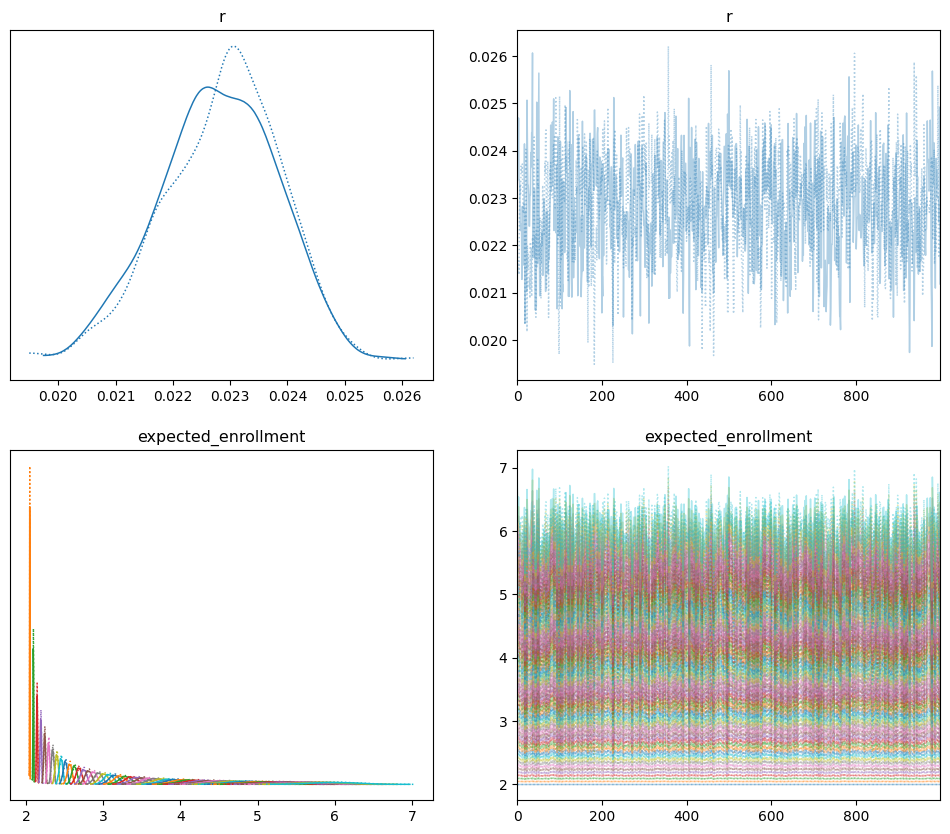

In [72]:
import arviz as az
import matplotlib.pyplot as plt

# with model:
#     summary = pm.summary(trace)
#     print(summary)

with model:
    az.plot_trace(trace, figsize=(12, 10))

# with model:
#     az.plot_posterior(trace, figsize=(2, 2))

